Image Processing For TOEIC-OMR-Grading

In [78]:
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [79]:
filename = "template_config.json"
try:
    with open(filename, 'r') as f:
        config = json.load(f)
    print("Cấu hình template đã được tải thành công!")
    print(config)
    bubble_markers_np = np.array(config['bubble_markers'], dtype=np.int32)
    config['x_coords'] = np.array(config['x_coords'], dtype=np.int32)
    config['y_coords'] = np.array(config['y_coords'], dtype=np.int32)

except FileNotFoundError:
    print(f"❌ Lỗi: Không tìm thấy file '{filename}'.")
except Exception as e:
    print(f"❌ Lỗi khi tải hoặc xử lý cấu hình: {e}")

Cấu hình template đã được tải thành công!
{'marker_scaling_ref': 0.041726618705035974, 'warp_size': {'width': 1320, 'height': 869}, 'bubble_markers': [[124, 1, 24, 24], [244, 1, 24, 24], [304, 1, 24, 24], [334, 1, 24, 24], [424, 1, 24, 24], [574, 1, 24, 24], [604, 1, 24, 24], [814, 1, 24, 24]], 'dash_markers': [[2, 158, 27, 10], [2, 189, 27, 9], [2, 218, 27, 9], [2, 248, 27, 10], [2, 279, 27, 9], [2, 309, 27, 9], [2, 338, 27, 9], [2, 368, 27, 10], [2, 398, 27, 10], [2, 429, 27, 9], [2, 458, 27, 9], [2, 488, 27, 10], [2, 519, 27, 9], [2, 549, 27, 9], [2, 578, 27, 9], [2, 608, 27, 9], [2, 638, 27, 10], [2, 669, 27, 9], [2, 698, 27, 9], [2, 728, 27, 10], [2, 759, 27, 9], [2, 789, 27, 9], [2, 818, 27, 9], [2, 848, 27, 9], [2, 879, 27, 9]], 'bubble_radius': 12, 'dash_size': [27, 9], 'x_coords': [135, 165, 195, 225, 285, 315, 345, 375, 435, 465, 495, 525, 585, 615, 645, 675, 795, 825, 855, 885, 945, 975, 1005, 1035, 1095, 1125, 1155, 1185, 1245, 1275, 1305, 1335], 'y_coords': [162, 192, 222,

Size: 4080 x 3060


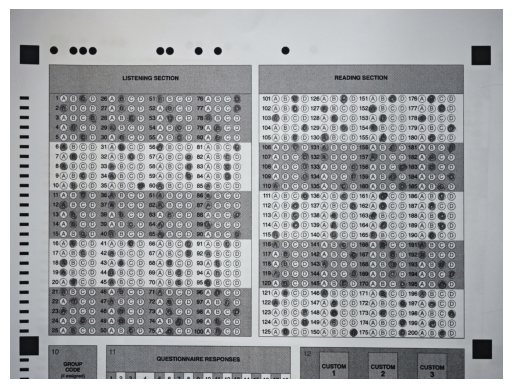

In [80]:
img_path = 'input.jpg' 

img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
if img is None:
    print("Không load được ảnh! Kiểm tra tên file và đường dẫn.")
else:
    print(f"Size: {img.shape[1]} x {img.shape[0]}")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

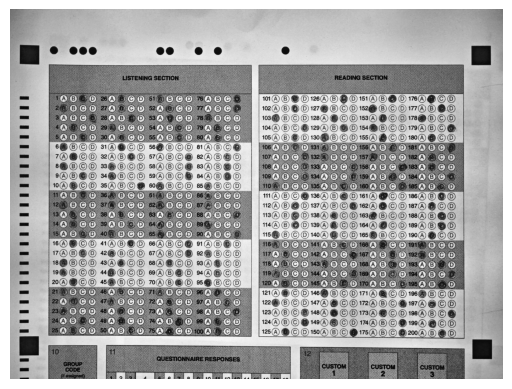

In [81]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_gray = clahe.apply(img_gray)
# Hiển thị ảnh grayscale
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.show()

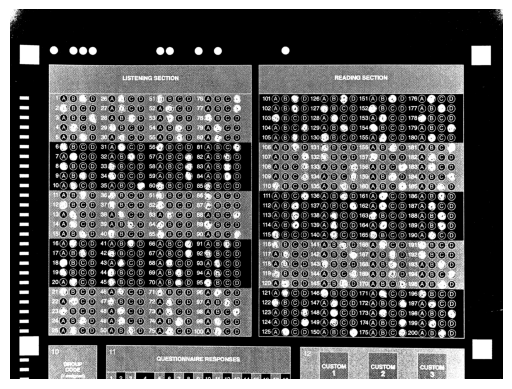

In [82]:
_, img_binary = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV)

plt.imshow(img_binary, cmap='gray')
plt.axis('off')
plt.show()

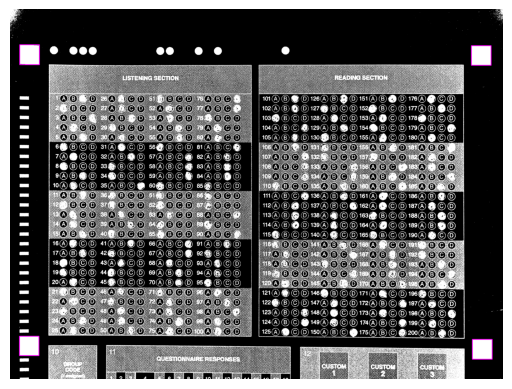

In [83]:
if img_binary is None:
    print("Chưa có ảnh binary!")
else:
    contours, _ = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    markers = []
    min_size = 0.5 * config['marker_scaling_ref'] * img_binary.shape[1]
    min_density = 0.7  # tối thiểu 70% pixel trắng trong bounding box
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w < min_size or h < min_size:
            continue
        aspect_ratio = w / h
        if not (0.8 <= aspect_ratio <= 1.2):
            continue 
        # Tính density (tỉ lệ pixel trắng)
        roi = img_binary[y:y+h, x:x+w]
        density = np.sum(roi==255) / (w*h)
        if density >= min_density:
            markers.append((x, y, w, h))
    img_display = cv2.cvtColor(img_binary.copy(), cv2.COLOR_GRAY2BGR)
    for (x, y, w, h) in markers:
        cv2.rectangle(img_display, (x, y), (x+w, y+h), (255,0,255), 5)
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

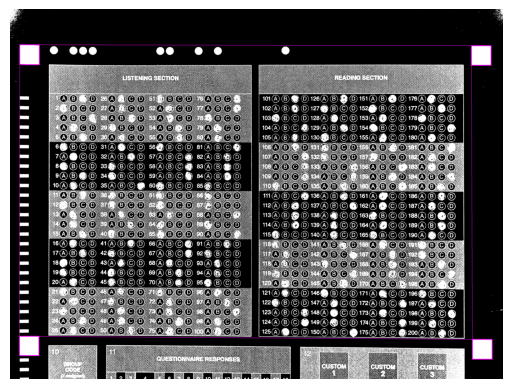

In [84]:
if len(markers) >= 4:
    # a. Sắp xếp 4 marker (sử dụng tâm)
    centers = np.array([[x + w//2, y + h//2] for x, y, w, h in markers])
    s = centers.sum(axis=1)
    diff = np.diff(centers, axis=1)

    tl_idx = np.argmin(s)
    br_idx = np.argmax(s)
    tr_idx = np.argmin(diff)
    bl_idx = np.argmax(diff)

    tl_rect = markers[tl_idx]
    tr_rect = markers[tr_idx]
    br_rect = markers[br_idx]
    bl_rect = markers[bl_idx]

    # Tọa độ này sẽ được dùng làm NGUỒN (Source) cho Perspective Warp
    SRC_POINTS = np.float32([
        [tl_rect[0], tl_rect[1]],  # 1. Góc TL của BB TL marker
        [tr_rect[0], tr_rect[1]],  # 2. Góc TL của BB TR marker
        [br_rect[0], br_rect[1]],  # 3. Góc TL của BB BR marker
        [bl_rect[0], bl_rect[1]]   # 4. Góc TL của BB BL marker
    ])

    cv2.polylines(img_display, [np.int32(SRC_POINTS)], True, (255, 0, 255), 2) 
    
else:
    print("⚠️ Không tìm thấy đủ 4 marker lớn để vẽ tứ giác Warp.")
plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

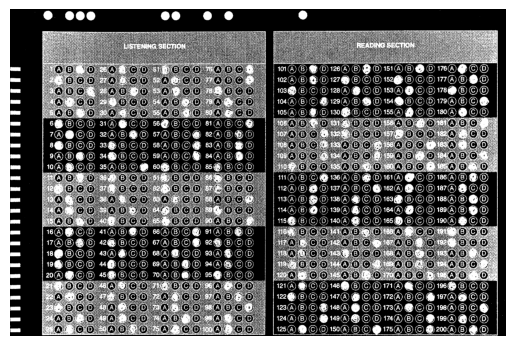

In [85]:
DST_POINTS = np.float32([
    [0, 0],                                                         # Top-Left
    [config['warp_size']['width'], 0],                              # Top-Right
    [config['warp_size']['width'], config['warp_size']['height']],  # Bottom-Right
    [0, config['warp_size']['height']]                              # Bottom-Left
])

  # Tính toán Ma trận biến đổi M
M = cv2.getPerspectiveTransform(SRC_POINTS, DST_POINTS)
# Che phủ marker tl bằng hình chữ nhật ĐẶC màu đen (giá trị 0)
x_tl, y_tl, w_tl, h_tl = tl_rect
cv2.rectangle(img_binary, (int(x_tl), int(y_tl)), (int(x_tl + w_tl), int(y_tl + h_tl)), 0, -1)

# Thực hiện Warp lên ảnh GỐC (img) về kích thước lý tưởng
img_warped = cv2.warpPerspective(img_binary, M, (config['warp_size']['width'], config['warp_size']['height']))

plt.imshow(cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

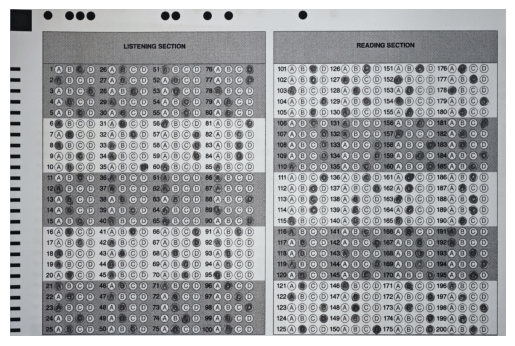

In [86]:
img = cv2.warpPerspective(img, M, (config['warp_size']['width'], config['warp_size']['height']))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

✅ Đã xác định 9 tâm X chuẩn: [101, 159, 187, 215, 413, 441, 525, 582, 779]
✅ Đã xác định 25 tâm Y chuẩn: [159, 188, 217, 246, 275, 304, 333, 362, 392, 420, 449, 478, 507, 536, 565, 594, 623, 652, 680, 709, 738, 767, 796, 825, 853]

--- THAM SỐ TEMPLATE MỚI (BUBBLE X) ---
Chiều rộng trung bình (W): 24.00 pixels
Chiều cao trung bình (H): 24.22 pixels
Bán kính chuẩn mới (R): 12.06 pixels

--- THAM SỐ TEMPLATE MỚI (DASH Y) ---
Chiều rộng trung bình (W): 28.04 pixels
Chiều cao trung bình (H): 11.08 pixels


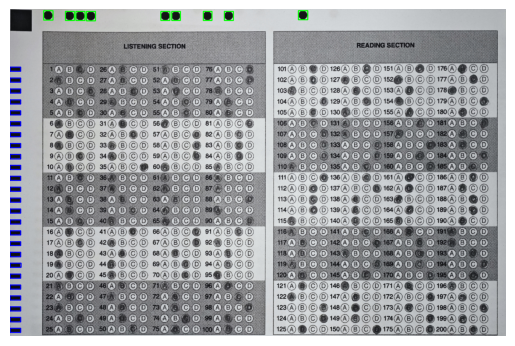


✅ Khung lưới tham chiếu 25x9 đã được xây dựng thành công.


In [87]:
H_new, W_new = img_warped.shape[:2]
SCAN_THICKNESS = 50 
X_MIN_SIZE = 19; X_MAX_SIZE = 29  # Kích thước W/H ~ 24 +/- 5
X_WH_RATIO_MIN = 0.8; X_WH_RATIO_MAX = 1.2 # Tỷ lệ ~ 1
Y_W_MIN = 22; Y_W_MAX = 32         # Kích thước W ~ 27 +/- 5
Y_H_MIN = 4; Y_H_MAX = 14  
# Khởi tạo các danh sách cuối cùng để lưu trữ dữ liệu Bounding Box (BB) đầy đủ
valid_contours_top = []
valid_contours_left = []
FINAL_X_INDICES = []
FINAL_Y_INDICES = []

# ====================================================================
# 1. QUÉT BIÊN TRÊN (TRỤC X: 9 BUBBLES) - ĐÃ SỬA LỖI LƯU TRỮ
# ====================================================================
top_scan_slice = img_warped[0:SCAN_THICKNESS, 0:W_new].copy()
contours_top, _ = cv2.findContours(top_scan_slice, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for c in contours_top:
    x, y, w, h = cv2.boundingRect(c)
    ratio = w / h if h > 0 else 0
    
    # LỌC: Kiểm tra kích thước xấp xỉ hình tròn (24x24)
    if (X_MIN_SIZE <= w <= X_MAX_SIZE and 
        X_MIN_SIZE <= h <= X_MAX_SIZE and
        X_WH_RATIO_MIN <= ratio <= X_WH_RATIO_MAX):
        
        center_x = x + w // 2
        # *** KHẮC PHỤC LỖI: LƯU TẤT CẢ DỮ LIỆU BB CẦN THIẾT ***
        valid_contours_top.append({
            'center_x': center_x, 
            'x': x, 
            'y': y, 
            'w': w, 
            'h': h
        })

# KIỂM TRA NGHIÊM NGẶT
if len(valid_contours_top) != 9:
    raise ValueError(f"❌ LỖI TEMPLATE: Biên trên tìm thấy {len(valid_contours_top)} bubble. YÊU CẦU 9.")

# Sắp xếp và trích xuất 9 chỉ mục X
valid_contours_top.sort(key=lambda item: item['center_x'])
FINAL_X_INDICES = [item['center_x'] for item in valid_contours_top]
print(f"✅ Đã xác định 9 tâm X chuẩn: {FINAL_X_INDICES}")

# ====================================================================
# 2. QUÉT BIÊN TRÁI (TRỤC Y: 25 DASHES) - ĐÃ SỬA LỖI LƯU TRỮ
# ====================================================================
left_scan_slice = img_warped[0:H_new, 0:SCAN_THICKNESS].copy()
contours_left, _ = cv2.findContours(left_scan_slice, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for c in contours_left:
    x, y, w, h = cv2.boundingRect(c)
    
    # LỌC: Kiểm tra kích thước xấp xỉ hình chữ nhật (27x9)
    if (Y_W_MIN <= w <= Y_W_MAX and 
        Y_H_MIN <= h <= Y_H_MAX):
        
        center_y = y + h // 2
        # *** KHẮC PHỤC LỖI: LƯU TẤT CẢ DỮ LIỆU BB CẦN THIẾT ***
        valid_contours_left.append({
            'center_y': center_y,
            'x': x, 
            'y': y, 
            'w': w, 
            'h': h
        })

# KIỂM TRA NGHIÊM NGẶT
if len(valid_contours_left) != 25:
    raise ValueError(f"❌ LỖI TEMPLATE: Biên trái tìm thấy {len(valid_contours_left)} dash. YÊU CẦU 25.")

# Sắp xếp và trích xuất 25 chỉ mục Y
valid_contours_left.sort(key=lambda item: item['center_y'])
FINAL_Y_INDICES = [item['center_y'] for item in valid_contours_left]
print(f"✅ Đã xác định 25 tâm Y chuẩn: {FINAL_Y_INDICES}")

# ====================================================================
# 3. TÍNH TOÁN VÀ LƯU THAM SỐ CHUẨN MỚI (CHẠY THÀNH CÔNG NHỜ LỖI ĐÃ ĐƯỢC SỬA)
# ====================================================================
# Danh sách chứa w và h thực tế của 9 bubble đã lọc
bubble_widths = [item['w'] for item in valid_contours_top]
bubble_heights = [item['h'] for item in valid_contours_top]

NEW_BUBBLE_W = np.mean(bubble_widths)
NEW_BUBBLE_H = np.mean(bubble_heights)
NEW_BUBBLE_R = (NEW_BUBBLE_W + NEW_BUBBLE_H) / 4 

print("\n--- THAM SỐ TEMPLATE MỚI (BUBBLE X) ---")
print(f"Chiều rộng trung bình (W): {NEW_BUBBLE_W:.2f} pixels")
print(f"Chiều cao trung bình (H): {NEW_BUBBLE_H:.2f} pixels")
print(f"Bán kính chuẩn mới (R): {NEW_BUBBLE_R:.2f} pixels")

# Danh sách chứa w và h thực tế của 25 dash đã lọc
dash_widths = [item['w'] for item in valid_contours_left]
dash_heights = [item['h'] for item in valid_contours_left]

NEW_DASH_W = np.mean(dash_widths)
NEW_DASH_H = np.mean(dash_heights)

print("\n--- THAM SỐ TEMPLATE MỚI (DASH Y) ---")
print(f"Chiều rộng trung bình (W): {NEW_DASH_W:.2f} pixels")
print(f"Chiều cao trung bình (H): {NEW_DASH_H:.2f} pixels")

# ====================================================================
# 4. TRỰC QUAN HÓA (ĐÃ SỬA LỖI TÍNH TOÁN TỌA ĐỘ)
# ====================================================================
# Sao chép ảnh màu gốc đã warp để vẽ lên (Giả định img_display tồn tại)
image_with_overlays = img.copy() 

# VẼ CÁC BUBBLE X (Dùng Bounding Box thực tế)
if valid_contours_top:
    for item in valid_contours_top:
        # Lấy trực tiếp tọa độ góc trên bên trái (x, y) từ Bounding Box
        x1 = item['x'] 
        y1 = item['y']
        x2 = x1 + item['w']
        y2 = y1 + item['h']
        cv2.rectangle(image_with_overlays, (x1, y1), (x2, y2), (0, 255, 0), 2) # Màu Xanh Lá

# VẼ CÁC DASH Y (Dùng Bounding Box thực tế)
if valid_contours_left: 
    for item in valid_contours_left:
        # Lấy trực tiếp tọa độ góc trên bên trái (x, y) từ Bounding Box
        x1 = item['x']
        y1 = item['y']
        x2 = x1 + item['w']
        y2 = y1 + item['h']
        cv2.rectangle(image_with_overlays, (x1, y1), (x2, y2), (255, 0, 0), 2) # Màu Xanh Dương

# HIỂN THỊ
plt.imshow(cv2.cvtColor(image_with_overlays, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# ====================================================================
# 5. XÂY DỰNG KHUNG LƯỚI THAM CHIẾU (Dùng tâm X, Y đã tính)
# ====================================================================
all_bubble_centers = []
for y in FINAL_Y_INDICES:
    row_centers = []
    for x in FINAL_X_INDICES:
        row_centers.append((x, y)) 
    all_bubble_centers.append(row_centers)
    
print(f"\n✅ Khung lưới tham chiếu {len(FINAL_Y_INDICES)}x{len(FINAL_X_INDICES)} đã được xây dựng thành công.")


--- 6. TÍNH TOÁN CÁC THAM SỐ CHUẨN ĐỘNG ---
Khoảng cách nhảy ngắn U (Đơn vị): 28.00
Khoảng cách dịch chuyển LC: 141.17
Khoảng cách nhảy lớn JUMP (Cột): 620.00
✅ Đã tạo 32 chỉ mục X chuẩn hóa cho 32 cột.
✅ Khung lưới tham chiếu cuối cùng 25x32 (25 hàng, 32 cột) đã được xây dựng.


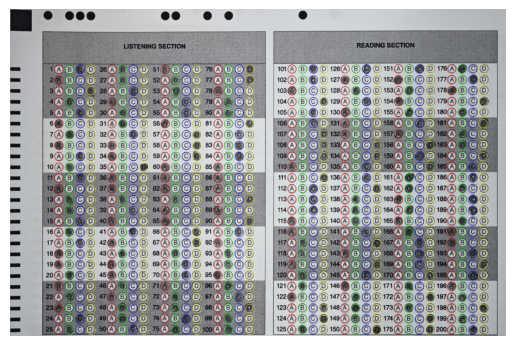


✅ Đã lưu: FINAL_X_INDICES_32 (32 cột), FINAL_Y_INDICES (25 hàng) cho bước trích xuất đáp án tiếp theo.


In [88]:
S = FINAL_X_INDICES 

print("\n--- 6. TÍNH TOÁN CÁC THAM SỐ CHUẨN ĐỘNG ---")

# 1. TÍNH TOÁN U (Khoảng cách nhảy ngắn)
# U = mean(x6-x5, x4-x3, x3-x2) => mean(S[5]-S[4], S[3]-S[2], S[2]-S[1])
U = np.mean([S[5] - S[4], S[3] - S[2], S[2] - S[1]])
print(f"Khoảng cách nhảy ngắn U (Đơn vị): {U:.2f}")

# 2. TÍNH TOÁN LC (Khoảng cách dịch chuyển cho cụm 2)
# LC = mean((x7 - x1)/2, x8-x6) => mean((S[6]-S[0])/2, S[7]-S[5])
LC = np.mean([(S[6] - S[0]) / 3, S[7] - S[5]])
print(f"Khoảng cách dịch chuyển LC: {LC:.2f}")

# 3. TÍNH TOÁN JUMP (Khoảng cách dịch chuyển cụm lớn)
# jump = x9 - x2 => S[8] - S[1]
JUMP = S[8] - S[1]
print(f"Khoảng cách nhảy lớn JUMP (Cột): {JUMP:.2f}")

# ====================================================================
# 7. XÂY DỰNG 32 CHỈ MỤC X CHUẨN HÓA (FINAL_X_INDICES_32)
# ====================================================================

FINAL_X_INDICES_32 = []
N = FINAL_X_INDICES_32 # Biến tham chiếu ngắn gọn

# Cụm 1: x1, x2, x3, x4
# x1 = (scanned_x2 - scanned_x1) / 2 => (S[1] - S[0]) / 2
N.append((S[1] + S[0]) / 2)
# x2, x3, x4 lần lượt = scanned_x2, x3, x4 => S[1], S[2], S[3]
N.extend([S[1], S[2], S[3]])
X_1_4 = N[:4] # Lưu trữ x1, x2, x3, x4 để dùng lại

# Cụm 2: x5, x6, x7, x8 
# x5, x6, x7, x8 lần lượt bằng LC cộng với x1, x2, x3, x4
N.extend([LC + x for x in X_1_4])

# Cụm 3: x9, x10, x11, x12
# x9, x10 lần lượt bằng scanned_x5, x6 => S[4], S[5]
N.extend([S[4], S[5]])
# x11, x12 lần lượt bằng x trước đó + U
N.append(N[-1] + U) # x11 = x10 + U
N.append(N[-1] + U) # x12 = x11 + U

# Cụm 4: x13, x14, x15, x16
# x13, x14, x15, x16 lần lượt bằng scanned_x8 + (-U, 0, +U, +2U) => S[7] + (...)
N.extend([
    S[7] - U,
    S[7],
    S[7] + U,
    S[7] + 2 * U
])

# Cụm 5 & 6 (Nhóm câu hỏi 2): x17 đến x32
# Từ x17 đến x32 lần lượt bằng JUMP + (x1 đến x16)
X_1_16 = N[:16]
N.extend([JUMP + x for x in X_1_16])

print(f"✅ Đã tạo {len(N)} chỉ mục X chuẩn hóa cho 32 cột.")

# ====================================================================
# 8. XÂY DỰNG KHUNG LƯỚI 25x32 CUỐI CÙNG VÀ TRỰC QUAN HÓA
# ====================================================================

final_reference_grid = []
for y in FINAL_Y_INDICES:
    row_centers = []
    for x in N:
        row_centers.append((int(x), int(y))) # Chuyển đổi sang int để vẽ
    final_reference_grid.append(row_centers)

print(f"✅ Khung lưới tham chiếu cuối cùng {len(FINAL_Y_INDICES)}x{len(N)} ({len(FINAL_Y_INDICES)} hàng, {len(N)} cột) đã được xây dựng.")

# --- TRỰC QUAN HÓA LƯỚI MỚI ---
# Sao chép ảnh để vẽ lên
image_with_grid = img.copy() 

# Vòng lặp qua lưới (25 hàng x 32 cột)
for i, row in enumerate(final_reference_grid):
    for j, (cx, cy) in enumerate(row):
        # Màu: Vòng lặp 4 cột để làm nổi bật nhóm A, B, C, D
        # 0: Đỏ (A), 1: Xanh lá (B), 2: Xanh dương (C), 3: Vàng (D)
        
        # J % 4: 0, 1, 2, 3, 0, 1, 2, 3...
        color_index = j % 4
        
        if color_index == 0: color = (0, 0, 255)    # Đỏ (Red)
        elif color_index == 1: color = (0, 255, 0)  # Xanh Lá (Green)
        elif color_index == 2: color = (255, 0, 0)  # Xanh Dương (Blue)
        else: color = (0, 255, 255)                 # Vàng (Yellow)
        
        # VẼ HÌNH TRÒN đại diện cho Bubble
        # Dùng R (bán kính trung bình) đã tính từ cell trước
        cv2.circle(image_with_grid, (cx, cy), int(NEW_BUBBLE_R), color, 1) # Vẽ viền

# HIỂN THỊ
plt.imshow(cv2.cvtColor(image_with_grid, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# ====================================================================
# 9. LƯU LƯỚI CUỐI CÙNG VÀ CÁC THAM SỐ
# ====================================================================
# Lưu các chỉ mục X và Y cuối cùng để sử dụng trong các bước trích xuất điểm.
FINAL_X_INDICES_32 = N
# FINAL_Y_INDICES đã là 25 chỉ mục Y đã sắp xếp từ cell trước.

print(f"\n✅ Đã lưu: FINAL_X_INDICES_32 ({len(FINAL_X_INDICES_32)} cột), FINAL_Y_INDICES ({len(FINAL_Y_INDICES)} hàng) cho bước trích xuất đáp án tiếp theo.")



✅ Đã hoàn tất quét 25x32 ô. Tổng số bubble được phát hiện: 199


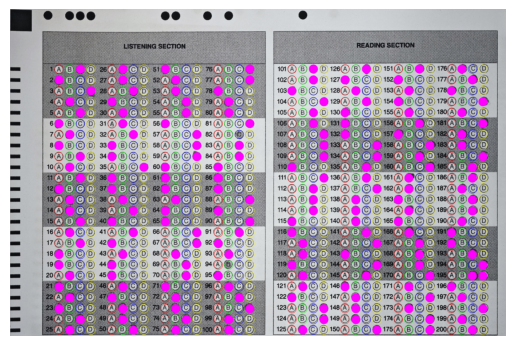

In [89]:
PIXEL_INTENSITY_THRESHOLD = 127 
MIN_FILL_PERCENTAGE = 0.50

try:
    # Dữ liệu lưới và kích thước
    X_CENTERS = FINAL_X_INDICES_32
    Y_CENTERS = FINAL_Y_INDICES
    R = int(NEW_BUBBLE_R) # Bán kính trung bình
    
    # image_with_grid (ảnh màu, có lưới) dùng cho VISUALIZATION
    detection_image = img_warped.copy() 
    
except NameError as e:
    print(f"❌ LỖI KHỞI TẠO: Một số biến từ cell trước không khả dụng ({e}). Vui lòng chạy cell trước đó.")
    raise

# ====================================================================
# 3. HÀM PHÁT HIỆN ĐÁP ÁN (DETECT_BUBBLE)
# ====================================================================
def detect_bubble(img_binary, center_x, center_y, R, threshold_value, min_fill_ratio):

    H, W = img_binary.shape[:2]
    
    # Xác định khu vực quan tâm (ROI)
    r_start = max(0, center_y - R)
    r_end = min(H, center_y + R)
    c_start = max(0, center_x - R)
    c_end = min(W, center_x + R)
    
    roi = img_binary[r_start:r_end, c_start:c_end]
    
    if roi.size == 0:
        return 0

    # Đếm số điểm ảnh tối (có cường độ nhỏ hơn hoặc bằng ngưỡng)
    dark_pixels = np.sum(roi >= threshold_value)
    
    # Tính tỷ lệ điền
    total_pixels = roi.size
    fill_ratio = dark_pixels / total_pixels
    
    # Quyết định kết quả
    if fill_ratio >= min_fill_ratio:
        return 1  # Đã tô
    else:
        return 0  # Chưa tô

result_matrix = np.zeros((len(Y_CENTERS), len(X_CENTERS)), dtype=int)
marked_circles = [] # Lưu trữ tọa độ của các bubble được tô

for i, center_y in enumerate(Y_CENTERS): # Lặp qua 25 hàng
    for j, center_x in enumerate(X_CENTERS): # Lặp qua 32 cột
        
        is_marked = detect_bubble(
            detection_image, 
            int(center_x), 
            int(center_y), 
            R, 
            PIXEL_INTENSITY_THRESHOLD, 
            MIN_FILL_PERCENTAGE
        )
        
        result_matrix[i, j] = is_marked
        
        if is_marked == 1:
            marked_circles.append((int(center_x), int(center_y)))

print(f"\n✅ Đã hoàn tất quét {result_matrix.shape[0]}x{result_matrix.shape[1]} ô. Tổng số bubble được phát hiện: {len(marked_circles)}")

MARKER_COLOR = (255, 0, 255) # Màu Magenta (Tím/Hồng đậm) cho bubble đã tô
FILLED_THICKNESS = -1        # Độ dày -1 để tô đầy hình tròn

for (cx, cy) in marked_circles:
    cv2.circle(image_with_grid, (cx, cy), R, MARKER_COLOR, FILLED_THICKNESS) 

plt.imshow(cv2.cvtColor(image_with_grid, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Lưu biến để dùng cho bước tiếp theo (xử lý đáp án)
OMR_RESULT_MATRIX = result_matrix